# Modelo básico de Expected Goals (xG) con StatsBomb Open Data
Este cuaderno crea un modelo simple de xG usando datos abiertos de StatsBomb, usando una regresión logística con dos variables: distancia y ángulo al arco.

In [13]:
# 🔧 Instalación de librerías necesarias
# Ejecuta esto solo si aún no tienes las bibliotecas
# !pip install pandas numpy matplotlib seaborn scikit-learn statsbombpy

Primero, importamos las librerías necesarias.

In [2]:
import pandas as pd
import numpy as np
from statsbombpy import sb
from math import atan2, degrees, sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

Cargamos los datos de StatsBomb.

In [3]:
# Cargar eventos del Mundial Femenino 2019
matches = sb.matches(competition_id=72, season_id=30)
match_id = matches.iloc[0]['match_id']

# Cargar eventos del partido
events = sb.events(match_id=match_id)

# Filtrar tiros
shots = events[events['type'] == 'Shot'].copy()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


Continuamos con ingeniería de variables.

In [4]:
def get_shot_features(df):
    # Coordenadas del arco en StatsBomb: (120, 40)
    goal_x, goal_y = 120, 40

    df['x'] = df['location'].apply(lambda loc: loc[0])
    df['y'] = df['location'].apply(lambda loc: loc[1])

    df['distance'] = np.sqrt((goal_x - df['x'])**2 + (goal_y - df['y'])**2)
    df['angle'] = df.apply(lambda row: abs(degrees(atan2(7.32 / 2, row['distance'])) * 2), axis=1)

    # Variable binaria: 1 si fue gol
    df['is_goal'] = df['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

    return df

shots = get_shot_features(shots)

Desarrollamos un modelo simple de regresión logística para calcular los xG.

In [5]:
# Selección de variables
X = shots[['distance', 'angle']]
y = shots['is_goal']

# Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluar modelo
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred_proba))

AUC: nan


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Visualizamos xG.

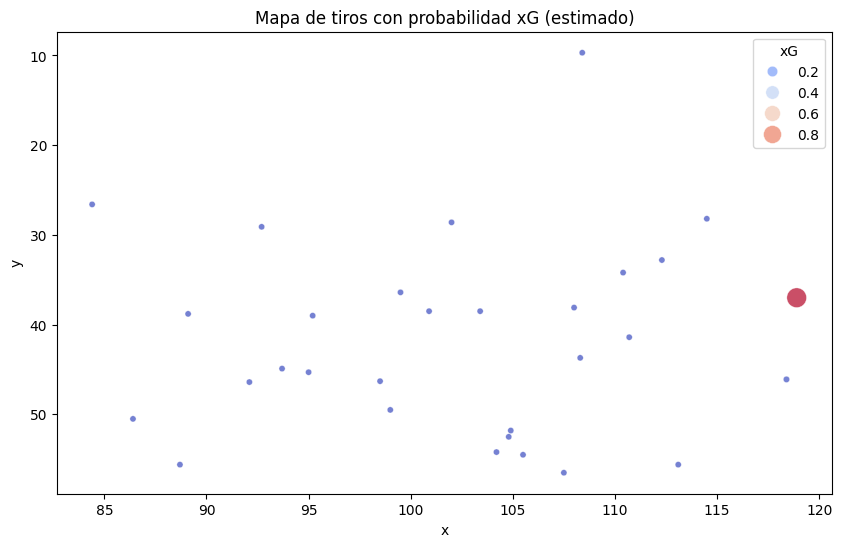

In [6]:
# Añadir predicción al dataframe
shots['xG'] = model.predict_proba(shots[['distance', 'angle']])[:, 1]

# Mapa de tiros con color según xG
plt.figure(figsize=(10, 6))
sns.scatterplot(data=shots, x='x', y='y', hue='xG', size='xG', palette='coolwarm', sizes=(20, 200), alpha=0.7)
plt.title('Mapa de tiros con probabilidad xG (estimado)')
plt.gca().invert_yaxis()
plt.show()

¡Ya tenemos nuestro modelo funcional de xG! Puede expandirse añadiendo más variables (por ejemplo: parte del cuerpo, presión defensiva, tipo de pase, etc.)